In [181]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import svm
from neuralforecast import NeuralForecast
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score

In [81]:
df = pd.read_table('SMSSpamCollection',
                   sep='\t', 
                   header=None, 
                   names=['label', 'text'])

In [82]:
#mudando de texto para numero, ham:0 and spam:1
encoder = LabelEncoder()
df['label']= encoder.fit_transform(df['label'])

In [83]:
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int32 
 1   text    5572 non-null   object
dtypes: int32(1), object(1)
memory usage: 65.4+ KB


In [85]:
df.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [86]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [87]:
df.shape

(5572, 2)

In [88]:
df['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

In [89]:
#buscando o número de caracteres em cada texto
df['num_characters'] = df['text'].apply(len)

In [90]:
df.head()

,label,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [91]:
#buscando o número de palavras em cada texto
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [92]:
df.head()

,label,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [93]:
#buscando numero de frases
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [94]:
df.head()

,label,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [95]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000
mean,80.489950,18.842426,2.006102
std,59.942907,13.851947,1.539977
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,62.000000,15.000000,2.000000
75%,122.000000,27.000000,3.000000
max,910.000000,220.000000,38.000000


In [96]:
#descrevendo o ham
df[df['label'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4825.000000,4825.000000,4825.000000
mean,71.482487,17.425699,1.846010
std,58.440652,14.118631,1.475377
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,93.000000,23.000000,2.000000
max,910.000000,220.000000,38.000000


In [97]:
#descrevendo o spam
df[df['label'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,747.000000,747.000000,747.000000
mean,138.670683,27.993307,3.040161
std,28.873603,6.860440,1.548499
min,13.000000,2.000000,1.000000
25%,133.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


### Análise gráfica

In [98]:
label_counts = df['label'].value_counts()

([<matplotlib.patches.Wedge at 0x2bc6f77c9a0>,
 [Text(-1.0038714981945518, 0.4497132587689916, 'ham'),
  Text(1.0038714771419537, -0.44971330576360763, 'spam')],
 [Text(-0.5475662717424827, 0.24529814114672266, '86.59%'),
  Text(0.5475662602592474, -0.2452981667801496, '13.41%')])

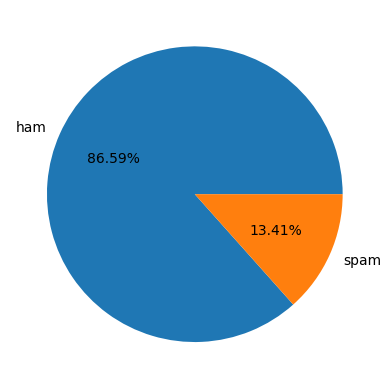

In [99]:
plt.pie(label_counts, labels=['ham', 'spam'], autopct="%0.2f%%")

<Axes: xlabel='num_characters', ylabel='Count'>

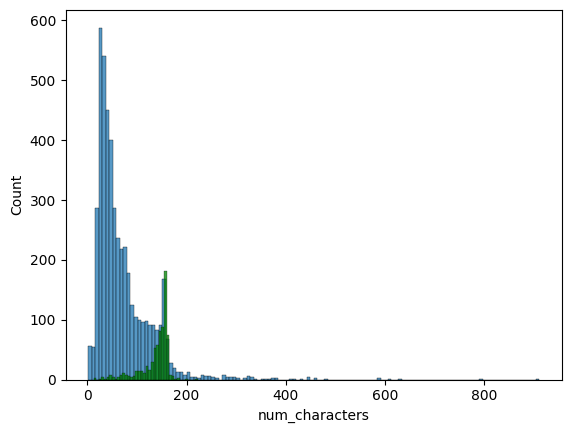

In [100]:
#plotting for ham and spam

sns.histplot(df[df['label'] == 0]['num_characters'])
sns.histplot(df[df['label'] == 1]['num_characters'] , color = 'green')

<Axes: xlabel='num_words', ylabel='Count'>

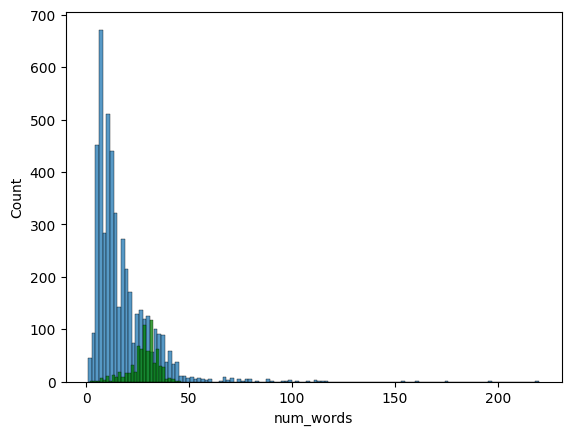

In [101]:
sns.histplot(df[df['label'] == 0]['num_words'])
sns.histplot(df[df['label'] == 1]['num_words'] , color = 'green')

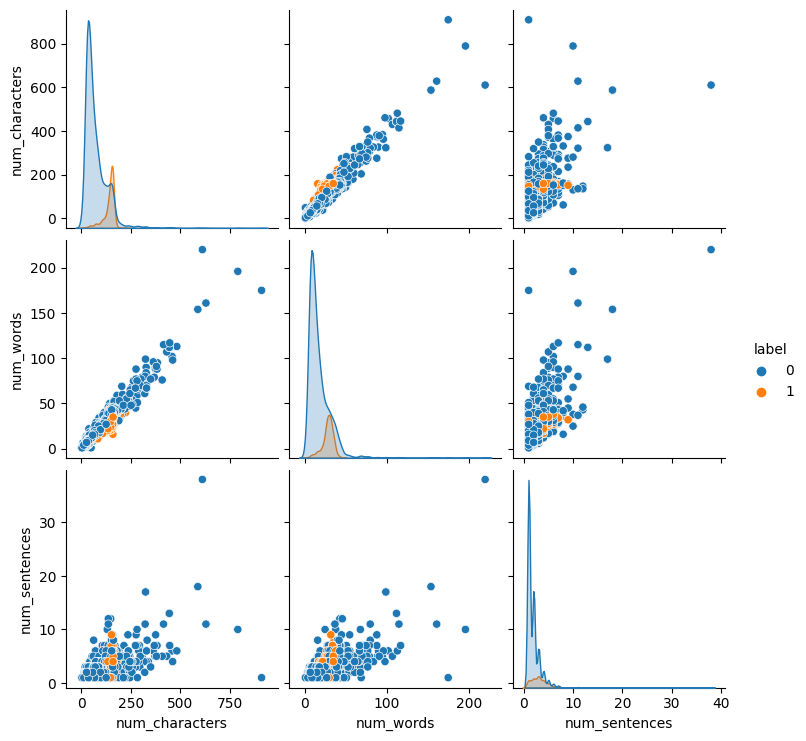

In [102]:
sns.pairplot(df,hue = 'label')

<Axes: >

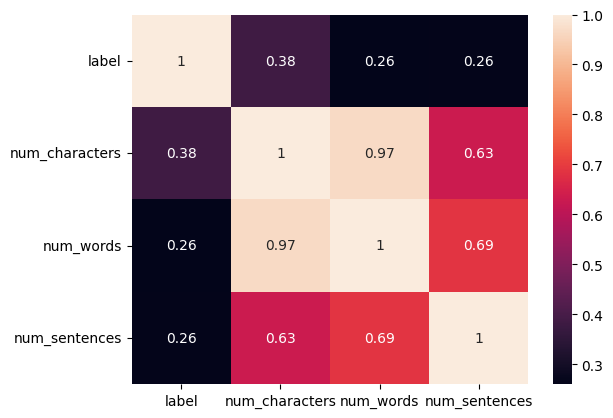

In [103]:
sns.heatmap(df.corr(),annot=True)

### Padronização

In [104]:
ps = PorterStemmer()

In [105]:
#criando a função para deixar o texto com letras minusculas, tokenização e remover os caracteres especiais
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)
  
  y = []
  for i in text:
    if i.isalnum():
      y.append(i)
  
  text = y[:]
  y.clear()

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)
  
  text = y[:]
  y.clear()
  
  for i in text:
    y.append(ps.stem(i))

  return " ".join(y) 

In [106]:
#verificando o funcionamento
nltk.download('stopwords')

transform_text('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [107]:
#criar coluna nova para o transform_text
df['transform_text'] = df['text'].apply(transform_text)

In [108]:
df.head()

,label,text,num_characters,num_words,num_sentences,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


### Modelos 

In [109]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [110]:
x = tfidf.fit_transform(df['transform_text']).toarray()
y = df['label'].values

In [111]:
X_train , X_test , y_train , y_test = train_test_split(x,y, test_size=0.2 , random_state=2)

### MultinomiaNB

In [115]:
mnb = MultinomialNB()

In [116]:
#MultinomialNB
mnb.fit(X_train , y_train)
y_pred1 = mnb.predict(X_test)
print(accuracy_score(y_test , y_pred1))
print(precision_score(y_test , y_pred1))

0.9721973094170404
1.0


### Random forest

In [117]:
rfc = RandomForestClassifier()

In [118]:
#RandomForestClassifier
rfc.fit(X_train, y_train)
y_pred2 = rfc.predict(X_test)
print(accuracy_score(y_test , y_pred2))
print(precision_score(y_test, y_pred2))

0.9739910313901345
1.0


### SVC

In [119]:
svc = SVC()

In [120]:
#SVC
svc.fit(X_train, y_train)
y_pred3 = svc.predict(X_test)
print(accuracy_score(y_test , y_pred3))
print(precision_score(y_test, y_pred3))

0.9730941704035875
0.9923076923076923


### BernoulliNB

In [121]:
bnb = BernoulliNB()

In [122]:
bnb.fit(X_train , y_train)
y_pred4 = bnb.predict(X_test)
print(accuracy_score(y_test , y_pred4))
print(precision_score(y_test , y_pred4))

0.9757847533632287
0.9851851851851852


### Gradient Boosting Classifier

In [123]:
gbc = GradientBoostingClassifier()

In [124]:
gbc.fit(X_train , y_train)
y_pred5 = gbc.predict(X_test)
print(accuracy_score(y_test , y_pred5))
print(precision_score(y_test , y_pred5))

0.9632286995515695
0.9606299212598425


### SVM

In [125]:
s = svm.SVC()

In [126]:
s.fit(X_train , y_train)
y_pred6 = gbc.predict(X_test)
print(accuracy_score(y_test , y_pred6))
print(precision_score(y_test , y_pred6))

0.9632286995515695
0.9606299212598425


### LSTM

In [182]:
# Preprocess the data
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [183]:
# Convert X_train and X_test to list of strings
X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]

# Tokenize the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [184]:
# Pad the sequences
X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

In [185]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=100),
    tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [186]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [190]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
140/140 [==============================] - 5s 38ms/step - loss: 0.3914 - accuracy: 0.8678
Epoch 2/5
140/140 [==============================] - 5s 37ms/step - loss: 0.3908 - accuracy: 0.8678
Epoch 3/5
140/140 [==============================] - 5s 36ms/step - loss: 0.3917 - accuracy: 0.8678
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 0.3908 - accuracy: 0.8678
Epoch 5/5
140/140 [==============================] - 5s 36ms/step - loss: 0.3914 - accuracy: 0.8678


In [191]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

35/35 [==============================] - 0s 8ms/step - loss: 0.4094 - accuracy: 0.8583
Accuracy: 0.8582959771156311
